# EEG to ECG Reconstruction


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from lib.gpr_utils import train_pulse
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from lib.utils import seed_everything
from lib.plot_utils import visualize_ecg_and_peaks, plot_augmentation_example, plot_train_hystory, visualize_predictions
from lib.dataset_utils import create_segments_sliding, create_training_segments_with_augmentation, create_segments_nonoverlapping, augment_segment
from lib.train_utils import evaluate_loader, subject_mae
from scipy.signal import butter, sosfiltfilt

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch version: 2.7.1+cu126
CUDA version: 12.6
Tesla T4
Using device: cuda


In [5]:
# Configuration
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length

# Available subjects
#subj_all = [29, 41, 30, 40, 23, 27, 28, 39]

subj_all = [29, 40, 23, 27, 28, 30, 33, 35, 36, 39, 45, 47, 49, 52, 57, 58, 62, 63, 64, 66, 69, 71, 73, 76, 82, 84, 88, 89, 90, 93, 95, 97, 98, 99, 100, 101, 103, 104, 105, 113, 117, 119, 120, 121,  106,  109, 110, 111,  112 ]  #41  118 107,

test_subj = subj_all[0:10]
val_subj = subj_all[10:15]
train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]

# Pulse type for ECG transformation Gaussian or Rectangular
impulse = "Gaussian"

# Augmentation settings
use_augmentation = False
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5

# Training settings
train_overlap = 0.0
batch_size = 16
learning_rate = 1e-3
epochs = 100
patience = 40

# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
parsed_path = os.path.join(cache_dir, "data_parsed.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed_full.pkl")

# Heart-rate band filtering (~1 Hz)
use_hr_band_filter = True
lowcut=0.1
highcut=16

# Use only the first N seconds of each subject (after downsampling)
dataset_max_seconds = 1000

## Load, Parse and Preprocess

In [6]:
def load_subject_data(subj_id, A, width, impulse):
    """Load and parse data for a single subject."""
    # Load preprocessed EEG
    data = loadmat(f'Signals/P0{subj_id:02d}_prepro.mat')
    EEG_prepro = data['EEG_prepro']
    Y_prepro = EEG_prepro['data'][0, 0].astype(float)
    freq_prepro = float(EEG_prepro['srate'][0, 0])

    # Load ECG
    ecg_data = loadmat(f'Signals/P0{subj_id:02d}.mat')
    t_prepro = ecg_data["t_int"].flatten()
    t_prepro = np.insert(t_prepro, 0, 0.0)

    R_peak = ecg_data['R_peak'].flatten() - 1
    ECG = ecg_data['ECG_i'].flatten()
    ECG = np.insert(ECG, len(ECG), ECG[-1])

    # Generate pulse train
    ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulse)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peak, 'EEG': Y_prepro, 'time': t_prepro, 'freq': freq_prepro }


def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)


def preprocess_subject_data(subject_data, tau):
    """Normalize and downsample subject data."""
    ECG = subject_data['ECG'].copy() - np.mean(subject_data['ECG'])
    ECG = ECG[::tau]  # downsample

    ECG_pulse = minmax_scale(subject_data['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
    ECG_pulse = ECG_pulse[::tau]

    EEG = minmax_scale(subject_data['EEG'].copy(), feature_range=(0, 1), axis=1)
    EEG = EEG - np.mean(EEG, axis=1, keepdims=True)  # Subtract per channel mean

    # Compute downsampled frequency
    freq = int(subject_data['freq'] / tau)

    # Downsample EEG
    EEG = EEG[:, ::tau]

    R_peaks = subject_data['R_peaks'].copy() // tau
    time = subject_data['time'].copy()[::tau]

    return {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq
    }

# Load parsed data
if os.path.exists(parsed_path) and os.path.exists(preproc_path):
    with open(parsed_path, "rb") as f:
       # data_parsed = pickle.load(f)
       pass
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded parsed and preprocess data from cache")
else:
    print("Loading and parsing raw data...")
    data_parsed = {}
    data_preprocessed = {}
    for ss in subj_all:
        print(f"  Loading subject {ss}...")
        data_parsed[ss] = load_subject_data(ss, A, width, impulse)
        data_preprocessed[ss] = preprocess_subject_data(data_parsed[ss], tau)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved to {parsed_path}")
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved to {preproc_path}")

# Apply HR band-pass AFTER loading (works with PKL cache)
if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = 500 #int(data_preprocessed[ss]['freq'])
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)

# Trim all signals to the first dataset_max_seconds seconds
if dataset_max_seconds is not None:
    for ss in subj_all:
        fs_ds = 500 # int(data_preprocessed[ss]['freq'])
        max_samples = int(dataset_max_seconds * fs_ds)
        # Bound against available length
        T = data_preprocessed[ss]['EEG'].shape[1]
        max_samples = min(max_samples, T)

        # Slice time-series
        data_preprocessed[ss]['EEG'] = data_preprocessed[ss]['EEG'][:, :max_samples]
        if 'EEG_unfilt' in data_preprocessed[ss]:
            data_preprocessed[ss]['EEG_unfilt'] = data_preprocessed[ss]['EEG_unfilt'][:, :max_samples]
        data_preprocessed[ss]['ECG'] = data_preprocessed[ss]['ECG'][:max_samples]
        data_preprocessed[ss]['ECG_pulse'] = data_preprocessed[ss]['ECG_pulse'][:max_samples]
        data_preprocessed[ss]['time'] = data_preprocessed[ss]['time'][:max_samples]

        # Keep R-peaks within the window
        rps = np.asarray(data_preprocessed[ss]['R_peaks'])
        data_preprocessed[ss]['R_peaks'] = rps[rps < max_samples]

# Visualize parsed data
#for ss in subj_all:
#    visualize_ecg_and_peaks(ss, data_parsed[ss], data_preprocessed[ss], duration_sec)

Loaded parsed and preprocess data from cache


In [7]:
# EEG pre/post-filter visualization with R-peaks (5 channels) + residual and metrics
'''plot_subj = test_subj  # subject to visualize

pre_ds = data_preprocessed[plot_subj].get('EEG_unfilt', None)
post_ds = data_preprocessed[plot_subj]['EEG']
fs_ds = data_preprocessed[plot_subj]['freq']
rpeaks_ds = data_preprocessed[plot_subj]['R_peaks']

# Reconstruct pre-filter downsampled EEG if not present in cache
if pre_ds is None:
    raw = data_parsed[plot_subj]['EEG'].copy()  # (C, T_full)
    raw = minmax_scale(raw, feature_range=(0, 1), axis=1)
    raw = raw - np.mean(raw, axis=1, keepdims=True)
    pre_ds = raw[:, ::tau]

n_channels = pre_ds.shape[0]
n_samp = min(int(duration_sec * fs_ds), pre_ds.shape[1])  # plot up to duration_sec
t = np.arange(pre_ds.shape[1]) / fs_ds

# Select 5 channels evenly across the montage
n_plot = 5
chan_idx = np.linspace(0, n_channels - 1, n_plot, dtype=int)
fig, axes = plt.subplots(n_plot, 1, figsize=(24, 2.6 * n_plot), sharex=True)

for i, ch in enumerate(chan_idx):
    ax = axes[i]
    y0 = pre_ds[ch, :n_samp]
    y1 = post_ds[ch, :n_samp]s

    ax.plot(t[:n_samp], y0, label='EEG pre-filter', color='C0', alpha=0.7)
    ax.plot(t[:n_samp], y1, label='EEG post-filter', color='C1', alpha=0.9)

    # R-peak vertical lines (downsampled indices)
    for rp in rpeaks_ds:
        if 0 <= rp < n_samp:
            ax.axvline(t[rp], color='r', linestyle='--', alpha=0.35, linewidth=1)
    ax.set_ylabel(f"Ch {ch}")
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Subject {plot_subj} — EEG pre/post HR-band filter with R-peaks', y=1.02)
plt.tight_layout()
plt.show()'''

'plot_subj = test_subj  # subject to visualize\n\npre_ds = data_preprocessed[plot_subj].get(\'EEG_unfilt\', None)\npost_ds = data_preprocessed[plot_subj][\'EEG\']\nfs_ds = data_preprocessed[plot_subj][\'freq\']\nrpeaks_ds = data_preprocessed[plot_subj][\'R_peaks\']\n\n# Reconstruct pre-filter downsampled EEG if not present in cache\nif pre_ds is None:\n    raw = data_parsed[plot_subj][\'EEG\'].copy()  # (C, T_full)\n    raw = minmax_scale(raw, feature_range=(0, 1), axis=1)\n    raw = raw - np.mean(raw, axis=1, keepdims=True)\n    pre_ds = raw[:, ::tau]\n\nn_channels = pre_ds.shape[0]\nn_samp = min(int(duration_sec * fs_ds), pre_ds.shape[1])  # plot up to duration_sec\nt = np.arange(pre_ds.shape[1]) / fs_ds\n\n# Select 5 channels evenly across the montage\nn_plot = 5\nchan_idx = np.linspace(0, n_channels - 1, n_plot, dtype=int)\nfig, axes = plt.subplots(n_plot, 1, figsize=(24, 2.6 * n_plot), sharex=True)\n\nfor i, ch in enumerate(chan_idx):\n    ax = axes[i]\n    y0 = pre_ds[ch, :n_samp

## Segmentation and Train/Val/Test Split

In [8]:
downsampled_frequency = data_preprocessed[subj_all[0]]['freq']
seg_len = int(duration_sec * downsampled_frequency)
aug_seg_len = int(aug_segment_duration * downsampled_frequency) if use_augmentation else seg_len
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))
n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]

print(f"Test subject: {test_subj} | Val subject: {val_subj} | Train subject: {train_subjects}")
print(f"Frequency: {downsampled_frequency} Hz | Segment length: {seg_len} samples ({duration_sec}s)")
print(f"Train overlap: {train_overlap:.2f}")

if use_augmentation:
    print(f"Augmentation: {n_augmented_per_segment}x per segment")
    print(f"Warp range: {warp_factor_range}")

Test subject: [29, 40, 23, 27, 28, 30, 33, 35, 36, 39] | Val subject: [45, 47, 49, 52, 57] | Train subject: [29, 40, 23, 27, 28, 30, 33, 35, 36, 39, 45, 47, 49, 52, 57, 58, 62, 63, 64, 66, 69, 71, 73, 76, 82, 84, 88, 89, 90, 93, 95, 97, 98, 99, 100, 101, 103, 104, 105, 113, 117, 119, 120, 121, 106, 109, 110, 111, 112]
Frequency: 500 Hz | Segment length: 5000 samples (10s)
Train overlap: 0.00


In [9]:
# --- Build training (unchanged) ---
X_train_list, y_train_list, ecg_train_list, train_ids_list = [], [], [], []

for s in train_subjects:
    print(f"Processing training subject {s}...", end="")

    if use_augmentation:
        X_s, y_s, ecg_s = create_training_segments_with_augmentation(
            data_preprocessed[s], aug_seg_len, seg_len, train_stride,
            warp_factor_range, n_augmented_per_segment
        )
        print(f"  Created {X_s.shape[0]} segments (with augmentation)")
    else:
        X_s, y_s, ecg_s = create_segments_sliding(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            data_preprocessed[s]['ECG'],
            seg_len, train_stride
        )
        print(f"  Created {X_s.shape[0]} segments")

    X_train_list.append(X_s)
    y_train_list.append(y_s)
    ecg_train_list.append(ecg_s)
    train_ids_list.append(np.full((X_s.shape[0],), s, dtype=np.int32))

# --- Build validation set from list of subjects (non-overlapping per subject) ---
X_val_list, y_val_list, ecg_val_list, val_ids_list = [], [], [], []

print()
for s in val_subj:
    print(f"Processing validation subject {s}...", end="")
    X_s, y_s, ecg_s = create_segments_nonoverlapping(
        data_preprocessed[s]['EEG'],
        data_preprocessed[s]['ECG_pulse'],
        data_preprocessed[s]['ECG'],
        seg_len
    )
    print(f"  Created {X_s.shape[0]} segments")
    X_val_list.append(X_s)
    y_val_list.append(y_s)
    ecg_val_list.append(ecg_s)
    val_ids_list.append(np.full((X_s.shape[0],), s, dtype=np.int32))

# --- Build test set from list of subjects (non-overlapping per subject) ---
X_test_list, y_test_list, ecg_test_list, test_ids_list = [], [], [], []

print()
for s in test_subj:
    print(f"Processing test subject {s}...", end="")
    X_s, y_s, ecg_s = create_segments_nonoverlapping(
        data_preprocessed[s]['EEG'],
        data_preprocessed[s]['ECG_pulse'],
        data_preprocessed[s]['ECG'],
        seg_len
    )
    print(f"  Created {X_s.shape[0]} segments")
    X_test_list.append(X_s)
    y_test_list.append(y_s)
    ecg_test_list.append(ecg_s)
    test_ids_list.append(np.full((X_s.shape[0],), s, dtype=np.int32))

# --- Concatenate (safely handle empty lists) ---
X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, seg_len, n_channels))
y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.empty((0, seg_len))
ECG_train = np.concatenate(ecg_train_list, axis=0) if ecg_train_list else np.empty((0, seg_len))
train_seg_subjects = np.concatenate(train_ids_list, axis=0) if train_ids_list else np.empty((0,), dtype=np.int32)

X_val = np.concatenate(X_val_list, axis=0) if X_val_list else np.empty((0, seg_len, n_channels))
y_val = np.concatenate(y_val_list, axis=0) if y_val_list else np.empty((0, seg_len))
ECG_val = np.concatenate(ecg_val_list, axis=0) if ecg_val_list else np.empty((0, seg_len))
val_seg_subjects = np.concatenate(val_ids_list, axis=0) if val_ids_list else np.empty((0,), dtype=np.int32)

X_test = np.concatenate(X_test_list, axis=0) if X_test_list else np.empty((0, seg_len, n_channels))
y_test = np.concatenate(y_test_list, axis=0) if y_test_list else np.empty((0, seg_len))
ECG_test = np.concatenate(ecg_test_list, axis=0) if ecg_test_list else np.empty((0, seg_len))
test_seg_subjects = np.concatenate(test_ids_list, axis=0) if test_ids_list else np.empty((0,), dtype=np.int32)

# --- Summary printout ---
print(f"\nFinal dataset:")
print(f"  Train: {X_train.shape} (subjects: {np.unique(train_seg_subjects) if train_seg_subjects.size else '[]'})")
print(f"  Val:   {X_val.shape} (subjects: {np.unique(val_seg_subjects) if val_seg_subjects.size else '[]'})")
print(f"  Test:  {X_test.shape} (subjects: {np.unique(test_seg_subjects) if test_seg_subjects.size else '[]'})")


Processing training subject 29...  Created 46 segments
Processing training subject 40...  Created 46 segments
Processing training subject 23...  Created 50 segments
Processing training subject 27...  Created 44 segments
Processing training subject 28...  Created 42 segments
Processing training subject 30...  Created 46 segments
Processing training subject 33...  Created 42 segments
Processing training subject 35...  Created 49 segments
Processing training subject 36...  Created 50 segments
Processing training subject 39...  Created 40 segments
Processing training subject 45...  Created 48 segments
Processing training subject 47...  Created 38 segments
Processing training subject 49...  Created 50 segments
Processing training subject 52...  Created 41 segments
Processing training subject 57...  Created 47 segments
Processing training subject 58...  Created 37 segments
Processing training subject 62...  Created 38 segments
Processing training subject 63...  Created 35 segments
Processing

In [10]:
# Visualize augmentation example
if use_augmentation and len(train_subjects) > 0:
    demo_subj = train_subjects[0]
    plot_augmentation_example(data_preprocessed, demo_subj, aug_seg_len, seg_len, warp_factor_range, downsampled_frequency)

In [11]:
# Create PyTorch datasets and loaders
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Created data loaders with training batch_size={batch_size}")

Created data loaders with training batch_size=16


## Model Definition

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()

    def forward(self, x):
        return self.dropout(self.net(x))


class UNet1D(nn.Module):
    def __init__(self, in_ch, base_ch=32, out_ch=1, dropout=0.2):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base_ch, dropout)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2, dropout)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4, dropout)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch * 4, base_ch * 8, dropout)

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4, dropout)
        self.up2 = nn.ConvTranspose1d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2, dropout)
        self.up1 = nn.ConvTranspose1d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch, dropout)

        self.out_conv = nn.Conv1d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, C) -> (B, C, T)
        
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        out = self.out_conv(d1)  # (B, 1, T)
        return out.squeeze(1)  # (B, T)


model = UNet1D(in_ch=n_channels, base_ch=16, out_ch=1, dropout=0.1).to(device)
summary(model, input_size=(1, seg_len, n_channels), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet1D                                   [1, 5000, 128]            [1, 5000]                 --
├─ConvBlock: 1-1                         [1, 128, 5000]            [1, 16, 5000]             --
│    └─Sequential: 2-1                   [1, 128, 5000]            [1, 16, 5000]             --
│    │    └─Conv1d: 3-1                  [1, 128, 5000]            [1, 16, 5000]             6,160
│    │    └─BatchNorm1d: 3-2             [1, 16, 5000]             [1, 16, 5000]             32
│    │    └─ReLU: 3-3                    [1, 16, 5000]             [1, 16, 5000]             --
│    │    └─Conv1d: 3-4                  [1, 16, 5000]             [1, 16, 5000]             784
│    │    └─BatchNorm1d: 3-5             [1, 16, 5000]             [1, 16, 5000]             32
│    │    └─ReLU: 3-6                    [1, 16, 5000]             [1, 16, 5000]             --
│    └─Dropout: 2-2            

## Training

Starting training...
Epoch 01 - train: 0.10643, val: 0.10814, test: 0.11548
Epoch 02 - train: 0.10586, val: 0.10691, test: 0.11424
Epoch 03 - train: 0.10557, val: 0.10325, test: 0.11031
Epoch 04 - train: 0.10559, val: 0.10727, test: 0.11463
Epoch 05 - train: 0.10550, val: 0.10533, test: 0.11368
Epoch 06 - train: 0.10536, val: 0.10904, test: 0.11470
Epoch 07 - train: 0.10528, val: 0.11057, test: 0.11597
Epoch 08 - train: 0.10499, val: 0.10293, test: 0.11006
Epoch 09 - train: 0.10493, val: 0.10275, test: 0.11026
Epoch 10 - train: 0.10488, val: 0.10189, test: 0.10778
Epoch 11 - train: 0.10462, val: 0.10142, test: 0.10880
Epoch 12 - train: 0.10490, val: 0.10325, test: 0.11147
Epoch 13 - train: 0.10444, val: 0.10411, test: 0.11198
Epoch 14 - train: 0.10429, val: 0.10296, test: 0.11133
Epoch 15 - train: 0.10403, val: 0.10554, test: 0.11358
Epoch 16 - train: 0.10416, val: 0.10686, test: 0.11182
Epoch 17 - train: 0.10369, val: 0.10695, test: 0.11406
Epoch 18 - train: 0.10360, val: 0.10393, tes

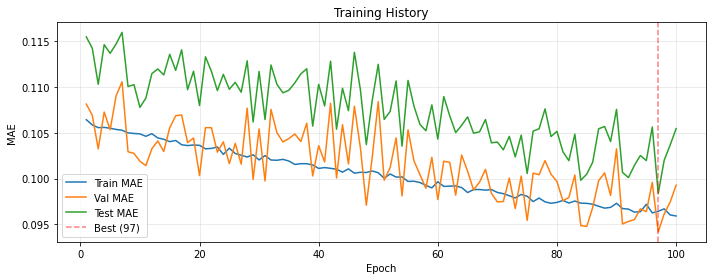

In [20]:
from lib.train_utils import check_early_stopping


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_mae_hist, val_mae_hist, test_mae_hist = [], [], []
best_val = float('inf')
best_state = None
wait = 0
best_epoch = 0

print("Starting training...")
for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_loss, train_mae, n_batches = 0.0, 0.0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += (pred.detach() - yb).abs().mean().item()
        n_batches += 1
    
    train_loss /= n_batches
    train_mae /= n_batches

    # Evaluate
    val_loss, val_mae = evaluate_loader(model, val_loader, device, criterion)
    test_loss, test_mae = evaluate_loader(model, test_loader, device, criterion)

    # Log
    train_mae_hist.append(train_mae)
    val_mae_hist.append(val_mae)
    test_mae_hist.append(test_mae)
    print(f"Epoch {epoch:02d} - train: {train_mae:.5f}, val: {val_mae:.5f}, test: {test_mae:.5f}")

    stopping, best_val, best_state, best_epoch, wait = check_early_stopping(epoch, val_mae, best_val, wait, patience, model, best_state, best_epoch)
    if stopping:
        break
    
# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Restored best model from epoch {best_epoch}")

plot_train_hystory(train_mae_hist, val_mae_hist, test_mae_hist, best_epoch)

## Evaluation and Visualization

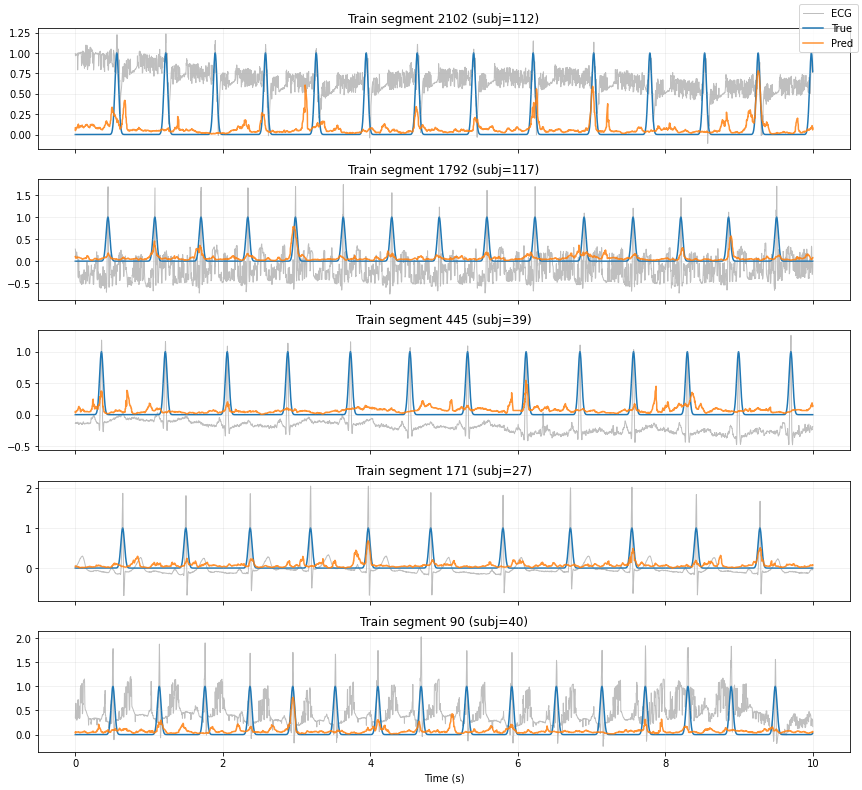

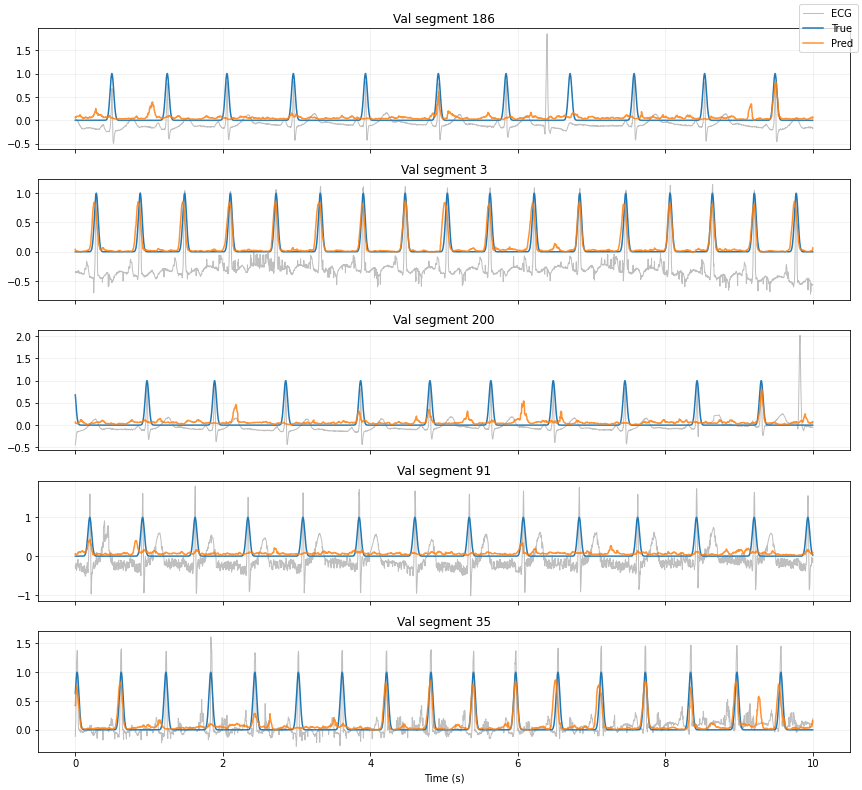

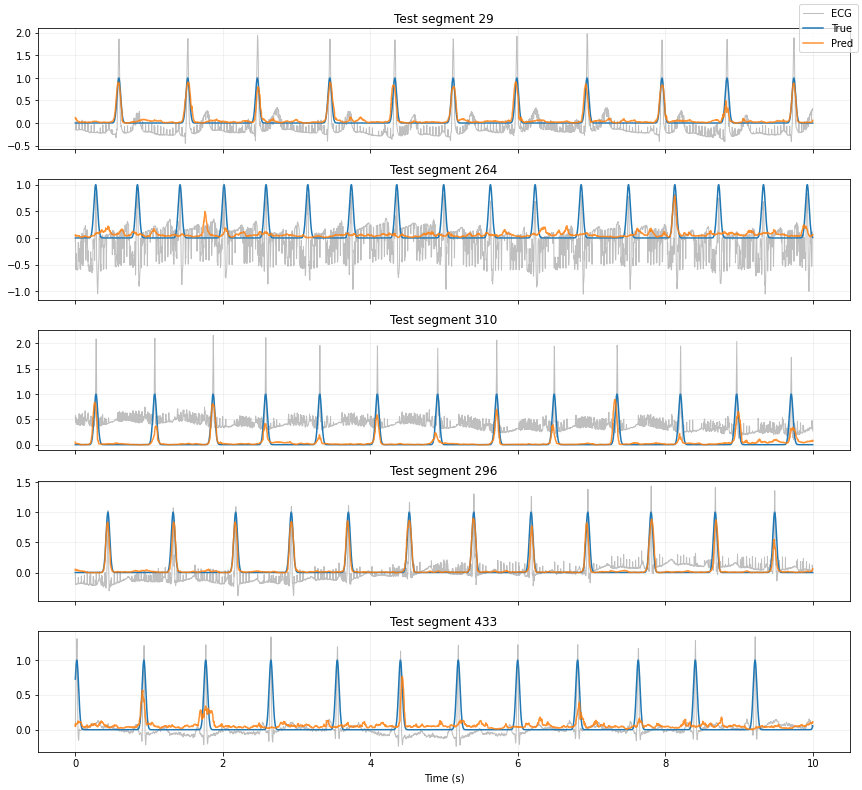

In [21]:
visualize_predictions('Train', X_train, y_train, ECG_train, model, seg_len, downsampled_frequency, device, train_seg_subjects, k=5)
visualize_predictions('Val', X_val, y_val, ECG_val, model, seg_len, downsampled_frequency, device, k=5)
visualize_predictions('Test', X_test, y_test, ECG_test, model, seg_len, downsampled_frequency, device, k=5)

In [22]:
# Per-subject training MAE
subject_mae(model, train_seg_subjects, X_train, y_train, device)

# Final evaluation
val_loss, val_mae = evaluate_loader(model, val_loader, device, criterion)
test_loss, test_mae = evaluate_loader(model, test_loader, device, criterion)

print(f"\nFinal Results:")
print(f"  Val MAE:  {val_mae:.5f}")
print(f"  Test MAE: {test_mae:.5f}")


Per-subject Training MAE:
  Subject 23: MAE = 0.09711 (50 segments)
  Subject 27: MAE = 0.10774 (44 segments)
  Subject 28: MAE = 0.10709 (42 segments)
  Subject 29: MAE = 0.07125 (46 segments)
  Subject 30: MAE = 0.12767 (46 segments)
  Subject 33: MAE = 0.04820 (42 segments)
  Subject 35: MAE = 0.07781 (49 segments)
  Subject 36: MAE = 0.10001 (50 segments)
  Subject 39: MAE = 0.10956 (40 segments)
  Subject 40: MAE = 0.11760 (46 segments)
  Subject 45: MAE = 0.07054 (48 segments)
  Subject 47: MAE = 0.10504 (38 segments)
  Subject 49: MAE = 0.12211 (50 segments)
  Subject 52: MAE = 0.05289 (41 segments)
  Subject 57: MAE = 0.10673 (47 segments)
  Subject 58: MAE = 0.08034 (37 segments)
  Subject 62: MAE = 0.09927 (38 segments)
  Subject 63: MAE = 0.12279 (35 segments)
  Subject 64: MAE = 0.12233 (41 segments)
  Subject 66: MAE = 0.12928 (41 segments)
  Subject 69: MAE = 0.11037 (47 segments)
  Subject 71: MAE = 0.07218 (48 segments)
  Subject 73: MAE = 0.06424 (43 segments)
  Subje

[Val] Peak timing MAE: 0.0295s | median: 0.0100s | p90: 0.0420s | Npeaks=1587 | dist=200 smp
[Test] Peak timing MAE: 0.0423s | median: 0.0140s | p90: 0.1280s | Npeaks=3050 | dist=200 smp


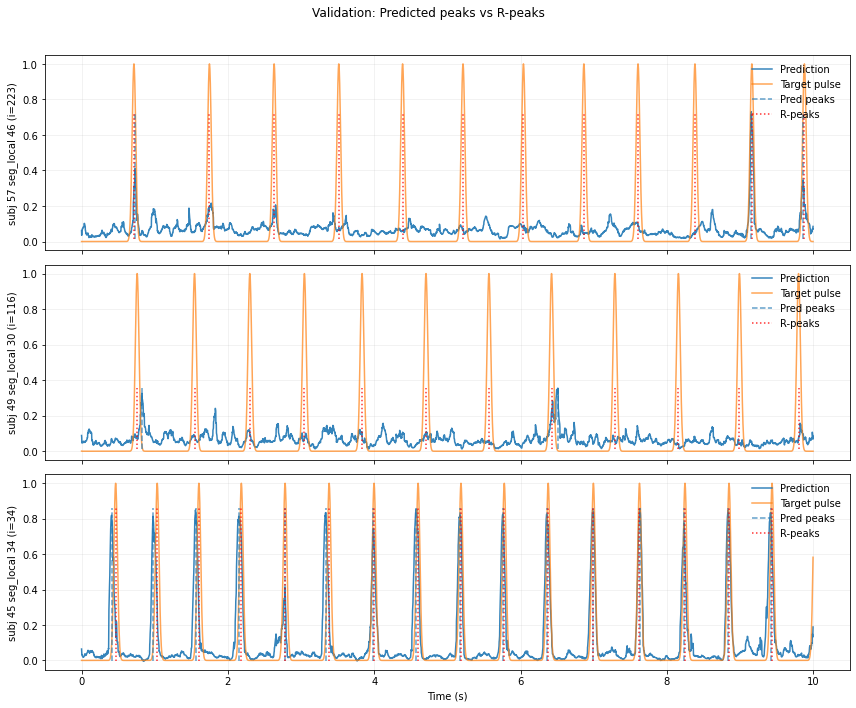

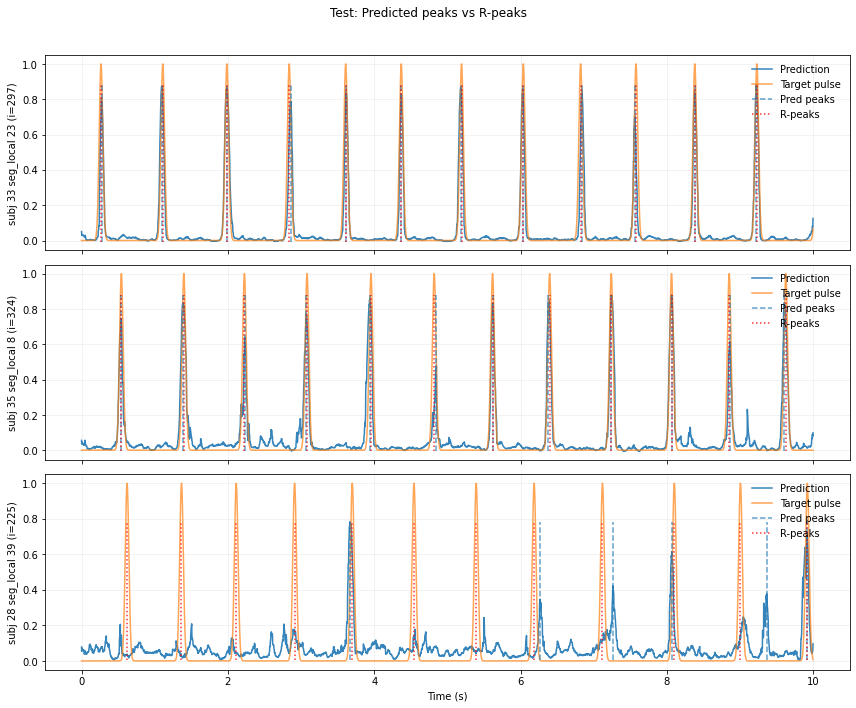

In [24]:
from scipy.signal import find_peaks

model.eval()

def nearest_diffs_samples(peaks_abs, r_abs):
    if peaks_abs.size == 0 or r_abs.size == 0:
        return np.empty((0,), dtype=float)
    diffs = []
    for p in peaks_abs:
        j = np.searchsorted(r_abs, p)
        cand = []
        if j < r_abs.size:
            cand.append(abs(r_abs[j] - p))
        if j > 0:
            cand.append(abs(r_abs[j - 1] - p))
        if cand:
            diffs.append(min(cand))
    return np.asarray(diffs, dtype=float)

def compute_peak_mae_for_set(X_set, seg_subjects, data_preprocessed, seg_len,
                             height=0.30, prominence=0.10, min_distance_s=0.4):
    """
    X_set: (N_segs, seg_len, ...) array
    seg_subjects: (N_segs,) array mapping each segment to subject id
    data_preprocessed: dict keyed by subject id with 'R_peaks' and 'freq'
    seg_len: samples per segment
    """
    if X_set.shape[0] == 0:
        return None, 0, None

    unique_subjs = np.unique(seg_subjects)
    # global fallback min distance in samples (using mean freq)
    avg_fs = np.mean([int(data_preprocessed[int(s)]['freq']) for s in unique_subjs])
    min_distance_samples_global = max(1, int(min_distance_s * avg_fs))

    all_diffs = []
    total_pred_peaks = 0

    # counters to compute local segment index per subject (assumes segments were created in the concatenation order)
    counters = {int(s): 0 for s in unique_subjs}

    with torch.no_grad():
        for i in range(X_set.shape[0]):
            s = int(seg_subjects[i])
            fs = int(data_preprocessed[s]['freq'])
            rpeaks_abs = np.asarray(data_preprocessed[s]['R_peaks'], dtype=int)
            min_distance_samples = max(1, int(min_distance_s * fs))

            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)  # (1, T, C)
            pred = model(xb).squeeze(0).detach().cpu().numpy()  # (T,)

            peaks_pred, _ = find_peaks(pred, distance=min_distance_samples, height=height, prominence=prominence)
            total_pred_peaks += int(peaks_pred.size)

            seg_local_idx = counters[s]
            seg_start = seg_local_idx * seg_len
            counters[s] += 1

            peaks_abs = peaks_pred + seg_start
            diffs = nearest_diffs_samples(peaks_abs, rpeaks_abs)
            if diffs.size:
                all_diffs.append(diffs)

    if len(all_diffs) == 0:
        return None, total_pred_peaks, min_distance_samples_global

    diffs_cat = np.concatenate(all_diffs)
    stats = {
        'mae_sec': float(diffs_cat.mean() / avg_fs),
        'median_sec': float(np.median(diffs_cat) / avg_fs),
        'p90_sec': float(np.percentile(diffs_cat, 90) / avg_fs)
    }
    return stats, total_pred_peaks, min_distance_samples_global


def plot_random_segments(X_set, y_set, seg_subjects, data_preprocessed, seg_len,
                         title_prefix, K=3, height=0.30, prominence=0.10, min_distance_s=0.4):
    if X_set.shape[0] == 0:
        print(f"[Plot] {title_prefix}: empty set, nothing to plot.")
        return
    rng = np.random.default_rng()
    Kp = min(K, X_set.shape[0])
    seg_indices = rng.choice(X_set.shape[0], size=Kp, replace=False)

    fig, axes = plt.subplots(Kp, 1, figsize=(12, 3.2 * Kp), sharex=True)
    if Kp == 1:
        axes = [axes]

    with torch.no_grad():
        for ax, i in zip(axes, seg_indices):
            s = int(seg_subjects[i])
            fs = int(data_preprocessed[s]['freq'])
            min_distance_samples = max(1, int(min_distance_s * fs))

            # compute local index of this segment for subject s by counting earlier segments
            seg_local_idx = int(np.count_nonzero(seg_subjects[:i] == s))
            seg_start = seg_local_idx * seg_len
            seg_end = seg_start + seg_len

            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)
            pred = model(xb).squeeze(0).detach().cpu().numpy()  # (T,)
            y_gt = y_set[i]

            peaks_pred, _ = find_peaks(pred, distance=min_distance_samples, height=height, prominence=prominence)

            rpeaks_abs = np.asarray(data_preprocessed[s]['R_peaks'], dtype=int)
            in_seg = (rpeaks_abs >= seg_start) & (rpeaks_abs < seg_end)
            rpeaks_rel = (rpeaks_abs[in_seg] - seg_start).astype(int)

            t_seg = np.arange(seg_len) / fs
            ax.plot(t_seg, pred, label='Prediction', alpha=0.9)
            ax.plot(t_seg, y_gt, label='Target pulse', alpha=0.7)

            if peaks_pred.size:
                ax.vlines(t_seg[peaks_pred], ymin=np.min(pred), ymax=np.max(pred),
                          linestyles='dashed', alpha=0.7, label='Pred peaks')
            if rpeaks_rel.size:
                ax.vlines(t_seg[rpeaks_rel], ymin=np.min(pred), ymax=np.max(pred),
                          linestyles='dotted', alpha=0.8, label='R-peaks', color='r')

            ax.set_ylabel(f"subj {s} seg_local {seg_local_idx} (i={i})")
            ax.grid(True, alpha=0.2)
            ax.legend(loc='upper right', frameon=False)

    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f"{title_prefix}: Predicted peaks vs R-peaks", y=1.02)
    plt.tight_layout()
    plt.show()


# ---- Prepare seg_subjects arrays if you didn't keep them when building sets ----
# Try to use val_seg_subjects/test_seg_subjects if present, otherwise reconstruct from val_subjs/test_subjs
try:
    val_seg_subjects  # noqa: F821
except NameError:
    # reconstruct subject mapping for val set
    val_seg_subjects_list = []
    for s in val_subjs:
        Xs, _, _ = create_segments_nonoverlapping(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            data_preprocessed[s]['ECG'],
            seg_len
        )
        val_seg_subjects_list.append(np.full((Xs.shape[0],), s, dtype=np.int32))
    if val_seg_subjects_list:
        val_seg_subjects = np.concatenate(val_seg_subjects_list, axis=0)
    else:
        val_seg_subjects = np.empty((0,), dtype=np.int32)

try:
    test_seg_subjects  # noqa: F821
except NameError:
    test_seg_subjects_list = []
    for s in test_subjs:
        Xs, _, _ = create_segments_nonoverlapping(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            data_preprocessed[s]['ECG'],
            seg_len
        )
        test_seg_subjects_list.append(np.full((Xs.shape[0],), s, dtype=np.int32))
    if test_seg_subjects_list:
        test_seg_subjects = np.concatenate(test_seg_subjects_list, axis=0)
    else:
        test_seg_subjects = np.empty((0,), dtype=np.int32)


# Peak detection params (shared)
height = 0.30
prominence = 0.10
min_distance_s = 0.4

# Validation set stats
val_stats, val_npk, val_min_dist = compute_peak_mae_for_set(
    X_val, val_seg_subjects, data_preprocessed, seg_len,
    height=height, prominence=prominence, min_distance_s=min_distance_s
)
if val_stats is None:
    print("[Val] No predicted peaks found with current detection parameters.")
else:
    print(f"[Val] Peak timing MAE: {val_stats['mae_sec']:.4f}s | median: {val_stats['median_sec']:.4f}s | p90: {val_stats['p90_sec']:.4f}s | Npeaks={val_npk} | dist={val_min_dist} smp")

# Test set stats
test_stats, test_npk, test_min_dist = compute_peak_mae_for_set(
    X_test, test_seg_subjects, data_preprocessed, seg_len,
    height=height, prominence=prominence, min_distance_s=min_distance_s
)
if test_stats is None:
    print("[Test] No predicted peaks found with current detection parameters.")
else:
    print(f"[Test] Peak timing MAE: {test_stats['mae_sec']:.4f}s | median: {test_stats['median_sec']:.4f}s | p90: {test_stats['p90_sec']:.4f}s | Npeaks={test_npk} | dist={test_min_dist} smp")

# Plots
plot_random_segments(X_val, y_val, val_seg_subjects, data_preprocessed, seg_len, title_prefix='Validation')
plot_random_segments(X_test, y_test, test_seg_subjects, data_preprocessed, seg_len, title_prefix='Test')
